In [1]:
#set up utlility
from networks.vae_blend import *
from util.helper import *
from networks.dynamic_planner import Dynamic_Planner
from mvae import *
from networks.metric import Metric
def noise(x):
    x_noise= - 2 * torch.ones_like(x,dtype=torch.float)
    return x_noise
config = Hparams()

m_net=Metric(config)  ## Other's vision Encoder via Metric Learning
m_net.load_state_dict(torch.load(config.metric_path))
m_net.eval()
model=blend_vae(config.in_chanels,config.out_chanels,config.in_shared,config.out_shared)  ##Robot Internal Model
model.load_state_dict(torch.load(config.mvae_path))
model.eval()   
dynamic_model=Dynamic_Planner(3,5,3,128)  ##Dynamic Planner model
dynamic_model.load_state_dict(torch.load('/docker-ros/local_ws/catkin_ws/src/data_collection/dynamic.ckpt'))
dynamic_model.eval()

agent=Agent(model,m_net,dynamic_model,'cuda') 



/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To test out the reconstruction abiltiy of the internal model

In [2]:
dataset=MVAE_DATA(config.babbling_data,config.blend_ann,'train')

im_test,joint_1,tip,_,joint_true,tip_true=dataset[2]
im_test=im_test.unsqueeze(0)

joint_test=torch.reshape(joint_1,(1,5))
joint_noise=noise(joint_test)
tip_test=torch.reshape(tip,(1,3))

            

tip_noise=noise(tip_test)


device='cuda'
total_tip_error=0
total_joint_error=0

for i in range(3165):
    im_test,joint_1,tip,_,joint_true,tip_true=dataset[i]
    im_test=im_test.unsqueeze(0)
    _,out_mu1,_=agent.self_recon([im_test.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
    
    self_joint=dataset.de_normalize(out_mu1[1].detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
    self_tip=dataset.de_normalize(out_mu1[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
    
    joint_true=dataset.de_normalize(joint_true.detach().cpu().numpy(),dataset.offset_joint,dataset.scale_joint)
    tip_true=dataset.de_normalize(tip_true.detach().cpu().numpy(),dataset.offset_tip,dataset.scale_tip)
    
    total_joint_error+=np.mean(abs(self_joint-joint_true))
    total_tip_error+=np.mean(abs(self_tip-tip_true))
    
print('reconsturcted e-e error:',total_tip_error/len(dataset),'joint error:',total_joint_error/len(dataset))
    

reconsturcted e-e error: 0.00019629288206396712 joint error: 0.0006726109884859836


Retargting function test

In [3]:
c=Contrastive_DATA(config.anchor_data,config.compare_data,config.full_ann,'test')
total_tip_error=[]
total_joint_error=[]
index=0
for i in range(len(c)):
    x1,y1,joint,tip=c[i]
    y=y1.unsqueeze(0) 
    x=x1.unsqueeze(0)
    
    joint=joint.detach().cpu().numpy()
    tip=tip.detach().cpu().numpy()
    
    tip_noise=noise(tip_test)
    _,out_mu,_=agent.map_recon([y.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
    _,out_mu1,_=agent.self_recon([x.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
    
    
    remap_joint=dataset.de_normalize(out_mu[1].detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
    remap_tip=dataset.de_normalize(out_mu[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
    
    self_joint=dataset.de_normalize(out_mu1[1].detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
    self_tip=dataset.de_normalize(out_mu1[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
    
    

    total_joint_error.append(np.mean(abs(joint-remap_joint)))
    total_tip_error.append(np.mean(abs(tip-remap_tip)))
    error_tip=tip-remap_tip
    error_joint=joint-remap_joint
print('retargeted joint error(mean and std):',np.mean(np.array(total_joint_error)),np.std(np.array(total_joint_error)))
print('retargeted e-e error (mean and std):',np.mean(np.array(total_tip_error)),np.std(np.array(total_tip_error)))


retargeted joint error(mean and std): 0.023704849648650723 0.016421488752616897
retargeted e-e error (mean and std): 0.008804873996220252 0.005353702648879066


One example of our retageting function

True Image:


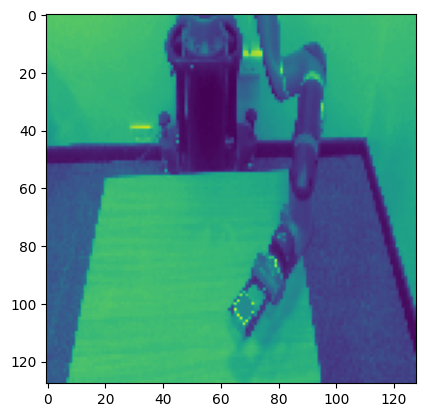

Human Image:


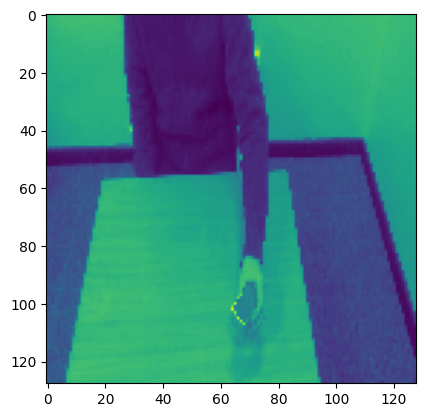

Retargted Image


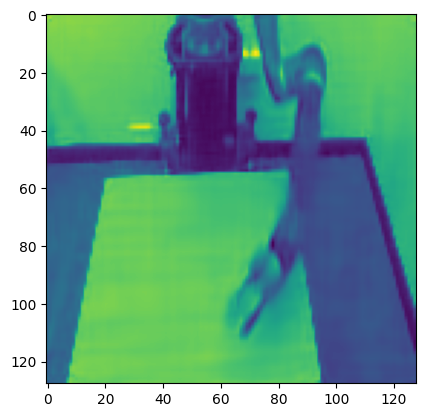

self recon


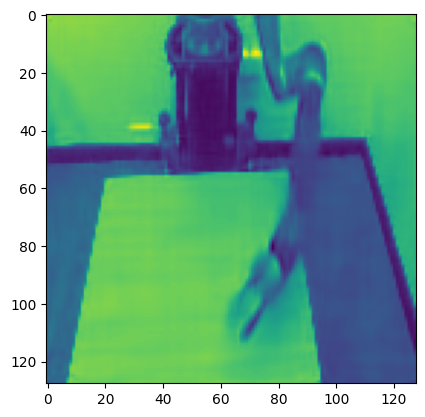

Retargetd (e-e and joints): [ 0.75401087  0.21608793 -0.03686045] [ 0.35286432 -2.32467294  1.10261264  1.13601493  0.46361679]
Self (e-e pose and joints): [ 0.74521766  0.2230807  -0.05281501] [ 0.37495033 -2.27128422  1.08275979  1.1368222   0.46523026]
True (e-e pose and joints): [ 0.7446802  0.2229488 -0.0515385] [ 0.37532032 -2.2764492   1.084205    1.1338174   0.46815136]


In [4]:
import cv2
c=Contrastive_DATA(config.anchor_data,config.compare_data,config.full_ann,'test')
x,y,joint,tip=c[32] 

print('True Image:')
_=imshow(x,1)

temp=torch.reshape(x,(1,128,128))
temp=temp*255
img=temp.detach().cpu().numpy()
img=img.transpose(1, 2, 0)



print('Human Image:')
_=imshow(y,1)

temp=torch.reshape(y,(1,128,128))
temp=temp*255
img=temp.detach().cpu().numpy()
img=img.transpose(1, 2, 0)



y=y.unsqueeze(0) 
x=x.unsqueeze(0)
tip_noise=noise(tip_test)
_,out_mu,_=agent.map_recon([y.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])



temp=out_mu[0]
    
temp=torch.reshape(temp,(1,128,128))
print('Retargted Image')
_=imshow(temp,1) 

temp=torch.reshape(temp,(1,128,128))
temp=temp*255
img=temp.detach().cpu().numpy()
img=img.transpose(1, 2, 0)

_,out_mu1,_=agent.self_recon([x.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
temp=out_mu1[0]
    
temp=torch.reshape(temp,(1,128,128))
remap_joint=dataset.de_normalize(out_mu[1].detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
remap_tip=dataset.de_normalize(out_mu[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
    
self_joint=dataset.de_normalize(out_mu1[1].detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
self_tip=dataset.de_normalize(out_mu1[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
print('self recon')

_=imshow(temp,1) #remapped image
print('Retargetd (e-e and joints):',remap_tip,remap_joint)
print('Self (e-e pose and joints):',self_tip,self_joint)
print('True (e-e pose and joints):',tip.detach().cpu().numpy(),joint.detach().cpu().numpy())




Utility Setup

In [5]:
import glob
def save_image(im,index,folder_path):
    temp=torch.reshape(im,(1,128,128))
    temp=temp*255
    img=temp.detach().cpu().numpy()
    img=img.transpose(1, 2, 0)
    cv2.imwrite(os.path.join(folder_path,f'out_{index}.jpg'),img)
        
def delete_image(folder_path):
     # Find all .jpg files in the folder
    jpg_files = glob.glob(os.path.join(folder_path, '*.jpg'))
   
    
    # Iterate through the list and delete each .jpg file
    for file_path in jpg_files:
        try:
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        except Exception as e:
            print(f"Error deleting {file_path}: {e}")
            

def translate_data_format(array):
    if torch.is_tensor(array):
        return array.detach().cpu().numpy()
    elif isinstance(array,np.ndarray):
        return torch.tensor(array,device='cuda',dtype=torch.float32)
    

Mental Simulation Function 

In [6]:
def mental_simulation(joint,tip_init,joint_goal,tip_goal,i,tip_true,save=False):
    
    diff=translate_data_format(tip_goal-tip_init)  
    actions=agent.action(diff)
    actions=translate_data_format(actions[0])
    joint=joint+actions
   
    next_joint=joint

    
    next_joint=dataset.normalize(next_joint,dataset.offset_joint,dataset.scale_joint)
    next_joint=translate_data_format(next_joint)

    _,out_mu,_=agent.self_recon([img_noise.to('cuda'),next_joint.unsqueeze(0),tip_noise.to('cuda')])
    temp=out_mu[0]
        
    temp=torch.reshape(temp,(1,128,128))
    if save:
      
        save_image(temp,i,folder_path)
    new_joint,new_tip=out_mu[1],out_mu[2]
    new_joint=translate_data_format(new_joint[0])
    new_joint=dataset.de_normalize(new_joint,dataset.offset_joint,dataset.scale_joint)

    new_tip=translate_data_format(new_tip[0])
    new_tip=dataset.de_normalize(new_tip,dataset.offset_tip,dataset.scale_tip)
    
    
    return new_joint,new_tip,tip_true-tip_init,joint_goal-joint

In [7]:
folder_path='/docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours'
delete_image(folder_path)
init=np.random.randint(0,3165)
init_image,joint_start,tip_start,_,_,_=dataset[71] #71


save_image(init_image,'0',folder_path)

c=Contrastive_DATA(config.anchor_data,config.compare_data,config.full_ann,'test')


x,goal,joint,tip=c[113] #113
joint_goal1=translate_data_format(joint)

save_image(goal,'goal',folder_path)


goal=goal.unsqueeze(0)
start=init_image.unsqueeze(0)

joint_noise=noise(joint_start)
joint_noise=joint_noise.unsqueeze(0)
joint=joint_start.unsqueeze(0)
tip_noise=-2*torch.ones((3),dtype=torch.float)
tip_noise=tip_noise.unsqueeze(0)

img_noise=noise(start)

# #set up goal
_,out_mu1,_=agent.map_recon([goal.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])

tip=dataset.de_normalize(out_mu1[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
    
tip_goal=tip
        

#set up init
_,out_mu2,_=agent.self_recon([start.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
joint_init=out_mu2[1]
tip_init=out_mu2[2]
joint_init=translate_data_format(joint_init[0])
tip_init=translate_data_format(tip_init[0])
joint_init=dataset.de_normalize(joint_init,dataset.offset_joint,dataset.scale_joint)
temp=out_mu2[0]
tip_init=dataset.de_normalize(tip_init,dataset.offset_tip,dataset.scale_tip)        
image_init=torch.reshape(temp,(1,128,128))


count=0


for i in range(1,11):
        
        
        joint_init,tip_init,error_tip,error_joint=mental_simulation(joint_init,tip_init,joint_goal1,tip_goal,i,tip_goal,save=True)        
           
        if np.mean(abs(error_tip))<=0.03:
                break
                
        





Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_1.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_5.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_4.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_goal.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_3.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_6.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_2.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_ours/out_0.jpg


In [8]:
#### Random trails
total_error_joints=[]
total_error_tips=[]
total_success_rate=[]
e_j=[]
e_t=[]
for _ in range(5):
    count=0
    error_joints=[]
    error_tips=[]
    for _ in range(100):
        init=np.random.randint(0,3165)
        goal_index=np.random.randint(0,len(c))

        init_image,joint_start,tip_start,_,_,_=dataset[init]
        

        c=Contrastive_DATA(config.anchor_data,config.compare_data,config.full_ann,'test')
        x,goal,joint,tip=c[goal_index] 
        joint_goal1=translate_data_format(joint)

        tip_true=translate_data_format(tip)
        goal=goal.unsqueeze(0)
        start=init_image.unsqueeze(0)

        joint_noise=noise(joint_start)
        joint_noise=joint_noise.unsqueeze(0)
        joint=joint_start.unsqueeze(0)
        tip_noise=-2*torch.ones((3),dtype=torch.float)
        tip_noise=tip_noise.unsqueeze(0)
        img_noise=noise(goal)
    
        #set up goal
        _,out_mu1,_=agent.map_recon([goal.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
        joint_goal=out_mu1[1]
        
        tip=dataset.de_normalize(out_mu1[2].detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
    
        tip_goal=tip
        

        #set up init
        _,out_mu2,_=agent.self_recon([start.to('cuda'),joint_noise.to('cuda'),tip_noise.to('cuda')])
        joint_init=out_mu2[1]
        tip_init=out_mu2[2]
        joint_init=translate_data_format(joint_init[0])
        tip_init=translate_data_format(tip_init[0])
        joint_init=dataset.de_normalize(joint_init,dataset.offset_joint,dataset.scale_joint)
        temp=out_mu2[0]
        tip_init=dataset.de_normalize(tip_init,dataset.offset_tip,dataset.scale_tip)        
        image_init=torch.reshape(temp,(1,128,128))

        error_j=[]
        error_t=[]
        flag=0
        
        for i in range(10):
            
            joint_init,tip_init,error_tip,error_joint=mental_simulation(joint_init,tip_init,joint_goal1,tip_goal,i,tip_true)
            
            
          
            if np.mean(abs(error_joint))<=0.05 and np.mean(abs(error_tip))<=0.03:
                error_joints.append(np.mean(abs(error_joint)))
                error_tips.append(np.mean(abs(error_tip)))
                count+=1
                break
               
                
           
            elif i==9:
             error_joints.append(np.mean(abs(error_joint)))
             error_tips.append(np.mean(abs(error_tip)))
             
      
    

    
              
    total_error_joints.append(error_joints)
    total_error_tips.append(error_tips)
    total_success_rate.append(count/100)


print('Joint mean error:',np.mean(np.array(total_error_joints)),'Joint std error:',np.std(np.array(total_error_joints)))
print('Tip mean error:',np.mean(np.array(total_error_tips)),'TIp std error:',np.std(np.array(total_error_tips)))
print('mean SR',np.mean(np.array(total_success_rate)),'Std SR:',np.std(np.array(total_success_rate)))

Joint mean error: 0.03338452776756042 Joint std error: 0.01641273030401641
Tip mean error: 0.015741939883743512 TIp std error: 0.007085447425952934
mean SR 0.93 Std SR: 0.019999999999999976


Compare AIF with our model for mental simulation

In [9]:
folder_path='/docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF'
delete_image(folder_path)




init_image,joint_start,tip_start,_,_,_=dataset[71]
save_image(init_image,'0',folder_path)

c=Contrastive_DATA(config.anchor_data,config.compare_data,config.full_ann,'test')

x,goal,joint,tip=c[113] #113
save_image(goal,'goal',folder_path)

goal=goal.unsqueeze(0)
start=init_image.unsqueeze(0)


agent.set_goal(goal.to('cuda'))
agent.init_latent(start.to('cuda'))
    
for i in range(1,30):
        Im,joint_,tip_=agent.perception()
        save_image(Im,i,folder_path)
                          
        remap_joint=dataset.de_normalize(joint_.detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
        remap_tip=dataset.de_normalize(tip_.detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
                    
        joint_temp=joint.detach().cpu().numpy()
        tip_temp=tip.detach().cpu().numpy()
        if np.mean(abs(remap_tip-tip_temp))<=0.03:
                break
        
        


       

Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_25.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_13.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_10.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_16.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_1.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_8.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_29.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_12.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_28.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_26.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_5.jpg
Deleted: /docker-ros/local_ws/Cognative_for_Imitation/m_s_result_AIF/out_4.jpg
Deleted: /docker-ros/local_ws/Cognative_for_

In [10]:

total_error_joints=[]
total_error_tips=[]
total_success_rate=[]
e_j1=[]
e_t1=[]
for _ in range(5):
    error_joints=[]
    error_tips=[]
    count=0
    for _ in range(100):
            init=np.random.randint(0,3165)
            goal=np.random.randint(0,len(c))


            init_image,joint_start,tip_start,_,_,_=dataset[init]

            
            c=Contrastive_DATA(config.anchor_data,config.compare_data,config.full_ann,'test')
            x,goal,joint,tip=c[goal] 
            joint=joint.detach().cpu().numpy()
            tip=tip.detach().cpu().numpy()
                            
            goal=goal.unsqueeze(0)
            start=init_image.unsqueeze(0)
                
            agent.set_goal(goal.to('cuda'))
            agent.init_latent(start.to('cuda'))
            error_j=[]
            error_t=[]
            flag=0    
            for i in range(1,51):
                
                Im,joint_,tip_=agent.perception()
                        
                        
                remap_joint=dataset.de_normalize(joint_.detach().cpu().numpy()[0],dataset.offset_joint,dataset.scale_joint)
                remap_tip=dataset.de_normalize(tip_.detach().cpu().numpy()[0],dataset.offset_tip,dataset.scale_tip)
                        
                
                error_joint=np.mean(abs(joint-remap_joint))
                error_tip=np.mean(abs(tip-remap_tip))
                
                if error_tip<=0.03 and error_joint<=0.05:
                        
                        error_tips.append(error_tip)
                        error_joints.append(error_joint)
                        count+=1
                        break
                        
                        
                elif i==50:
                        error_tips.append(error_tip)
                        error_joints.append(error_joint)
                        
                error_t.append(error_tip)
                error_j.append(error_joint)
                 
            e_j1.append(error_j)
            e_t1.append(error_t)    
                        
    total_error_joints.append(error_joints)
    total_error_tips.append(error_tips)
    total_success_rate.append(count/100)
                    
print('Joint mean error:',np.mean(np.array(total_error_joints)),'Joint std error:',np.std(np.array(total_error_joints)))
print('Tip mean error:',np.mean(np.array(total_error_tips)),'TIp std error:',np.std(np.array(total_error_tips)))
print('mean SR',np.mean(np.array(total_success_rate)),'Std SR:',np.std(np.array(total_success_rate)))

Joint mean error: 0.04394856984674311 Joint std error: 0.014645304366503846
Tip mean error: 0.025799161261552295 TIp std error: 0.011902170082894365
mean SR 0.858 Std SR: 0.05035871324805669
